In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('GDP Current Prices IMF DATA.csv',parse_dates=['YEAR'], index_col=['YEAR'])

In [3]:
df.head()

,GDP
YEAR,
2000-01-01,11.340
2001-01-01,11.243
2002-01-01,10.734
2003-01-01,9.573
2004-01-01,9.465


In [4]:
## confirming the time index is correctly set and in chronological order
if not isinstance(df.index, pd.DatetimeIndex):
    print("Warning:The index is not a DatetimeIndex.")
else:
    print("The index is correctly set as a DatetimeIndex.")

    if df.index.is_monotonic_increasing:
        print("The time index is in chronological order.")
    else:
        print("Warning: The time index is not in chronological order.")
        df = df.sort_index()
        print("The DataFrame has been sorted in chronological order.")
df.head()

The index is correctly set as a DatetimeIndex.
The time index is in chronological order.


,GDP
YEAR,
2000-01-01,11.340
2001-01-01,11.243
2002-01-01,10.734
2003-01-01,9.573
2004-01-01,9.465


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2000-01-01 to 2023-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GDP     24 non-null     float64
dtypes: float64(1)
memory usage: 384.0 bytes


In [6]:
df.shape

(24, 1)

In [7]:
df.describe()

,GDP
count,24.000000
mean,17.987583
std,9.736549
min,6.707000
25%,9.642750
50%,15.608500
75%,23.038250
max,36.922000


In [8]:
## Plotting the data for use in ARIMA Modelling
import plotly.express as px
fig = px.line(df, x=df.index, y= 'GDP',
              labels =({'Python':'Python', 'YEAR':'YEAR'}))
fig.update_layout(template = 'simple_white', font = dict(size=18),
                  title_text='Zimbabwe GDP from 2000-2023', width =650, title_x=0.5, height=400)
fig.show()

## Volatility Patterns

The data exhibits heteroscedasticity, varying volatility over time. The post 2017 period shows much higher volatility compared to ealier periods.


In [9]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue=dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue<0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is Not stationary')

In [10]:
def adfuller_test(data):
    result=adfuller(data)
    labels =['ADF test statistic','p-value','#lags Used','Number of observation Used']
    for value,label in zip(result,labels):
        print(label+' : ' +str(value))
        if result[1] <= 0.05:
            print('strong evidence against null hypothesis, Data is stationary')
        else:
            print('Data is non stationary')

In [11]:
adfuller_test(df)

ADF test statistic : -1.758309073725791
Data is non stationary
p-value : 0.4013475564381096
Data is non stationary
#lags Used : 9
Data is non stationary
Number of observation Used : 14
Data is non stationary


In [12]:
## First Difference
df_diff=df.diff()
df_diff=df_diff.dropna()

In [13]:
df_diff.head(10)

,GDP
YEAR,
2001-01-01,-0.097
2002-01-01,-0.509
2003-01-01,-1.161
2004-01-01,-0.108
2005-01-01,-0.420
2006-01-01,-0.904
2007-01-01,-0.357
2008-01-01,-1.077
2009-01-01,2.959


In [14]:
adfuller_test(df_diff)

ADF test statistic : -5.3371331804851225
strong evidence against null hypothesis, Data is stationary
p-value : 4.584755885905617e-06
strong evidence against null hypothesis, Data is stationary
#lags Used : 9
strong evidence against null hypothesis, Data is stationary
Number of observation Used : 13
strong evidence against null hypothesis, Data is stationary


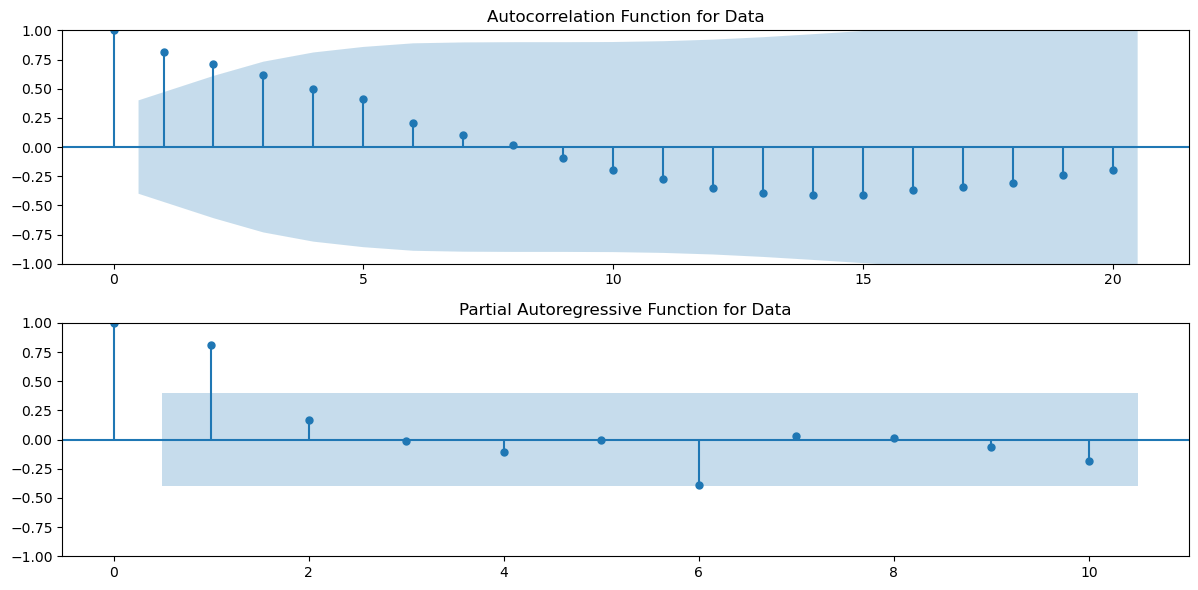

In [15]:
## ACF and PACF plots for original data
fig,(ax1,ax2)=plt.subplots(nrows=2,figsize=(12,6))
plot_acf(df,lags=20,ax=ax1)
ax1.set_title('Autocorrelation Function for Data')
plot_pacf(df, lags=10, ax=ax2)
ax2.set_title('Partial Autoregressive Function for Data')
plt.tight_layout()
plt.show()


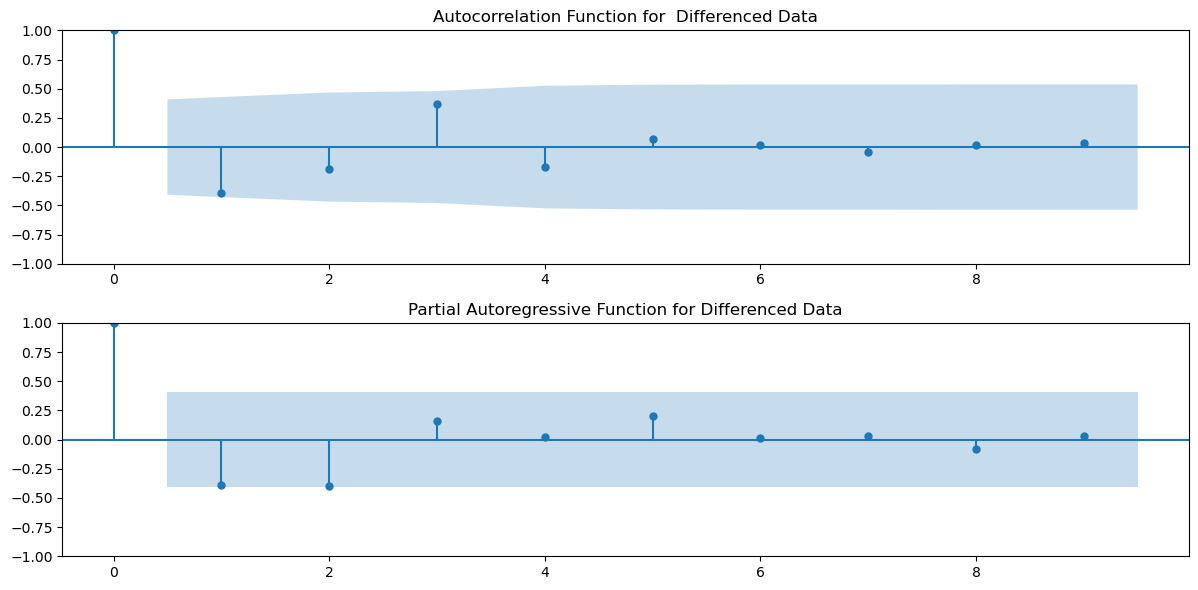

In [133]:
## ACF and PACF plots for differenced data
fig,(ax1,ax2)=plt.subplots(nrows=2,figsize=(12,6))
plot_acf(df_diff,lags=9,ax=ax1)
ax1.set_title('Autocorrelation Function for  Differenced Data')
plot_pacf(df_diff, lags=9, ax=ax2)
ax2.set_title('Partial Autoregressive Function for Differenced Data')
plt.tight_layout()
plt.savefig('Autocorrelation.png', dpi=300, bbox_inches='tight')  # Save line
plt.show()

### First forecast 2000-2009 forecasting 2010

In [17]:
pip install numpy scipy scikit-learn statsmodels cython

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
# Fit auto_arima model
from pmdarima import auto_arima
model = auto_arima(df['GDP'],     # set True if your data has seasonality
                   stepwise=True,       # stepwise search to reduce computation
                   suppress_warnings=True,
                   trace=True)          # print model selection process

# Best model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=137.618, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=137.977, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=136.246, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=134.558, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=137.187, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=136.466, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=137.071, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=136.412, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.879 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -64.279
Date:                Thu, 13 Nov 2025   AIC                   

In [20]:
ts=df['GDP']

In [21]:
train0= ts['2000':'2008']
actual_2009 = ts['2009']

In [22]:
model_1 = ARIMA(train0, order=(0,1,1))
model_fit_1= model_1.fit()
print(model_fit_1.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                    9
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  -7.504
Date:                Thu, 13 Nov 2025   AIC                             19.008
Time:                        13:32:48   BIC                             19.167
Sample:                    01-01-2000   HQIC                            17.936
                         - 01-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9973     36.877      0.027      0.978     -71.281      73.276
sigma2         0.2911     10.733      0.027      0.978     -20.745      21.327
Ljung-Box (L1) (Q):                   3.70   Jarque-

In [23]:
forecast_2009 = model_fit_1.forecast(steps=1)
print('Forecasted GDP for 2009:', forecast_2009.iloc[0])
print('Actual GDP for 2009:', actual_2009)

Forecasted GDP for 2009: 5.894672532385992
Actual GDP for 2009: YEAR
2009-01-01    9.666
Name: GDP, dtype: float64


In [24]:
model0 = ARIMA(train0, order=(1,1,1))
model_fit0= model0.fit()
print(model_fit0.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                    9
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  -5.748
Date:                Thu, 13 Nov 2025   AIC                             17.495
Time:                        13:32:48   BIC                             17.734
Sample:                    01-01-2000   HQIC                            15.888
                         - 01-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.223      4.478      0.000       0.562       1.438
ma.L1         -0.9858     27.611     -0.036      0.972     -55.103      53.131
sigma2         0.1776      4.727      0.038      0.9

In [25]:
forecast_2009 = model_fit0.forecast(steps=1)
print('Forecasted GDP for 2009:', forecast_2009.iloc[0])
print('Actual GDP for 2009:', actual_2009)

Forecasted GDP for 2009: 6.165431408875035
Actual GDP for 2009: YEAR
2009-01-01    9.666
Name: GDP, dtype: float64


In [26]:
mae0 = mean_absolute_error(forecast_2009, actual_2009)
mse0 = mean_squared_error(forecast_2009, actual_2009)
RMSE0 = np.sqrt(mse0)

def mean_absolute_percentage_error(actual_2009, forecast_2009):
    forecast_2009, actual_2009 = np.array(actual_2009), np.array(forecast_2009)
    return np.mean(np.abs((actual_2009-forecast_2009)/ forecast_2009))*100

mape0 = mean_absolute_percentage_error(actual_2009, forecast_2009)

print(f"MAE: {mae0:.2f}")
print(f"MSE: {mse0:.2f}")
print(f"RMSE: {RMSE0:.2f}")
print(f"MAPE: {mape0:.2f}%")

MAE: 3.50
MSE: 12.25
RMSE: 3.50
MAPE: 36.22%


In [27]:
actual_2011 = ts['2011']
forecast_2011_3step = model_fit0.forecast(steps=3)
print('Forecasted GDP for 2011:', forecast_2011_3step.iloc[2])
print('Actual GDP for 2011:', actual_2011)

Forecasted GDP for 2011: 5.082386773528757
Actual GDP for 2011: YEAR
2011-01-01    14.102
Name: GDP, dtype: float64


In [28]:
mae00 = mean_absolute_error([forecast_2011_3step.iloc[2]], actual_2011)
mse00 = mean_squared_error([forecast_2011_3step.iloc[2]], actual_2011)
RMSE00 = np.sqrt(mse00)

def mean_absolute_percentage_error(actual_2011, forecast_2011_3step):
    forecast_2011_3step, actual_2011 = np.array(actual_2011), np.array(forecast_2011_3step)
    return np.mean(np.abs((actual_2011-forecast_2011_3step)/ forecast_2011_3step))*100

mape00 = mean_absolute_percentage_error(actual_2011, forecast_2011_3step)

print(f"MAE: {mae00:.2f}")
print(f"MSE: {mse00:.2f}")
print(f"RMSE: {RMSE00:.2f}")
print(f"MAPE: {mape00:.2f}%")

MAE: 9.02
MSE: 81.35
RMSE: 9.02
MAPE: 60.12%


In [29]:
actual_2012 = ts['2012']
forecast_2012_4step = model_fit0.forecast(steps=4)
print('Forecasted GDP for 2012:', forecast_2012_4step.iloc[3])
print('Actual GDP for 2012:', actual_2012)

Forecasted GDP for 2012: 4.5409107257929575
Actual GDP for 2012: YEAR
2012-01-01    17.115
Name: GDP, dtype: float64


In [30]:
mae000 = mean_absolute_error([forecast_2012_4step.iloc[3]], actual_2012)
mse000 = mean_squared_error([forecast_2012_4step.iloc[3]], actual_2012)
RMSE000 = np.sqrt(mse000)

def mean_absolute_percentage_error(actual_2012, forecast_2012_4step):
    forecast_2012_4step, actual_2012 = np.array(actual_2012), np.array(forecast_2012_4step)
    return np.mean(np.abs((actual_2012-forecast_2012_4step)/ forecast_2012_4step))*100

mape000 = mean_absolute_percentage_error(actual_2012, forecast_2012_4step)

print(f"MAE: {mae000:.2f}")
print(f"MSE: {mse000:.2f}")
print(f"RMSE: {RMSE000:.2f}")
print(f"MAPE: {mape000:.2f}%")

MAE: 12.57
MSE: 158.11
RMSE: 12.57
MAPE: 68.72%


In [31]:
train=ts['2000':'2009']
actual_2010 = ts['2010']

In [32]:
model1 = ARIMA(train, order=(1,1,1))
model_fit1= model1.fit()
print(model_fit1.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   10
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -14.129
Date:                Thu, 13 Nov 2025   AIC                             34.258
Time:                        13:32:48   BIC                             34.850
Sample:                    01-01-2000   HQIC                            32.981
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6548      4.340     -0.151      0.880      -9.160       7.851
ma.L1          0.3853      4.641      0.083      0.934      -8.710       9.481
sigma2         1.3317      1.498      0.889      0.3

In [33]:
forecast_2010 = model_fit1.forecast(steps=1)
print('Forecasted GDP for 2010:', forecast_2010.iloc[0])
print('Actual GDP for 2010:', actual_2010)

Forecasted GDP for 2010: 8.760320900590616
Actual GDP for 2010: YEAR
2010-01-01    12.042
Name: GDP, dtype: float64


In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(forecast_2010, actual_2010)
mse = mean_squared_error(forecast_2010, actual_2010)
RMSE = np.sqrt(mse)

# MAPE
def mean_absolute_percentage_error(actual_2010, forecast_2010):
    forecast_2010, actual_2010 = np.array(actual_2010), np.array(forecast_2010)
    return np.mean(np.abs((actual_2010-forecast_2010)/ forecast_2010))*100

mape = mean_absolute_percentage_error(actual_2010, forecast_2010)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {RMSE:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 3.28
MSE: 10.77
RMSE: 3.28
MAPE: 27.25%


In [35]:
actual_2012 = ts['2012']
forecast_2012_3step = model_fit1.forecast(steps=3)
print('Forecasted GDP for 2012:', forecast_2012_3step.iloc[2])
print('Actual GDP for 2012:', actual_2012)

Forecasted GDP for 2012: 8.965038382183515
Actual GDP for 2012: YEAR
2012-01-01    17.115
Name: GDP, dtype: float64


In [36]:
mae01 = mean_absolute_error([forecast_2012_3step.iloc[2]], actual_2012)
mse01 = mean_squared_error([forecast_2012_3step.iloc[2]], actual_2012)
RMSE01 = np.sqrt(mse01)

def mean_absolute_percentage_error(actual_2012, forecast_2012_3step):
    forecast_2012_3step, actual_2012 = np.array(actual_2012), np.array(forecast_2012_3step)
    return np.mean(np.abs((actual_2012-forecast_2012_3step)/ forecast_2012_3step))*100

mape01 = mean_absolute_percentage_error(actual_2012, forecast_2012_3step)

print(f"MAE: {mae01:.2f}")
print(f"MSE: {mse01:.2f}")
print(f"RMSE: {RMSE01:.2f}")
print(f"MAPE: {mape01:.2f}%")

MAE: 8.15
MSE: 66.42
RMSE: 8.15
MAPE: 47.26%


In [37]:
actual_2013 = ts['2013']
forecast_2013_4step = model_fit1.forecast(steps=4)
print('Forecasted GDP for 2013:', forecast_2013_4step.iloc[3])
print('Actual GDP for 2013:', actual_2013)


Forecasted GDP for 2013: 9.219309239925987
Actual GDP for 2013: YEAR
2013-01-01    19.091
Name: GDP, dtype: float64


In [38]:
mae001 = mean_absolute_error([forecast_2013_4step.iloc[3]], actual_2013)
mse001 = mean_squared_error([forecast_2013_4step.iloc[3]], actual_2013)
RMSE001 = np.sqrt(mse001)

def mean_absolute_percentage_error(actual_2013, forecast_2013_4step):
    forecast_2013_4step, actual_2013 = np.array(actual_2013), np.array(forecast_2013_4step)
    return np.mean(np.abs((actual_2013-forecast_2013_4step)/ forecast_2013_4step))*100

mape001 = mean_absolute_percentage_error(actual_2013, forecast_2013_4step)

print(f"MAE: {mae001:.2f}")
print(f"MSE: {mse001:.2f}")
print(f"RMSE: {RMSE001:.2f}")
print(f"MAPE: {mape001:.2f}%")

MAE: 9.87
MSE: 97.45
RMSE: 9.87
MAPE: 52.47%


In [39]:
train1=ts['2000':'2010']
actual_2011 = ts['2011']

In [40]:
model2= ARIMA(train1, order=(1,1,1))
model_fit2= model2.fit()
print(model_fit2.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   11
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -16.380
Date:                Thu, 13 Nov 2025   AIC                             38.759
Time:                        13:32:48   BIC                             39.667
Sample:                    01-01-2000   HQIC                            37.764
                         - 01-01-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5192      4.050     -0.128      0.898      -8.457       7.418
ma.L1          0.9959    126.003      0.008      0.994    -245.965     247.957
sigma2         1.3490    166.353      0.008      0.9

In [41]:
forecast_2011 = model_fit2.forecast(steps=1)
print('Forecasted GDP for 2011:', forecast_2011.iloc[0])
print('Actual GDP for 2011:', actual_2011)

Forecasted GDP for 2011: 11.624938054870311
Actual GDP for 2011: YEAR
2011-01-01    14.102
Name: GDP, dtype: float64


In [42]:
mae1 = mean_absolute_error(forecast_2011, actual_2011)
mse1 = mean_squared_error(forecast_2011, actual_2011)
RMSE1 = np.sqrt(mse1)

# MAPE
def mean_absolute_percentage_error(actual_2011, forecast_2011):
    forecast_2011, actual_2011 = np.array(actual_2011), np.array(forecast_2011)
    return np.mean(np.abs((actual_2011-forecast_2011)/ forecast_2011))*100

mape1 = mean_absolute_percentage_error(actual_2011, forecast_2011)

print(f"MAE: {mae1:.2f}")
print(f"MSE: {mse1:.2f}")
print(f"RMSE: {RMSE1:.2f}")
print(f"MAPE: {mape1:.2f}%")

MAE: 2.48
MSE: 6.14
RMSE: 2.48
MAPE: 17.57%


In [43]:
actual_2013 = ts['2013']
forecast_2013_3step = model_fit2.forecast(steps=3)
print('Forecasted GDP for 2013:', forecast_2013_3step.iloc[2])
print('Actual GDP for 2013:', actual_2013)

Forecasted GDP for 2013: 11.729049725796466
Actual GDP for 2013: YEAR
2013-01-01    19.091
Name: GDP, dtype: float64


In [44]:
mae02 = mean_absolute_error([forecast_2013_3step.iloc[2]], actual_2013)
mse02 = mean_squared_error([forecast_2013_3step.iloc[2]], actual_2013)
RMSE02 = np.sqrt(mse02)

def mean_absolute_percentage_error(actual_2013, forecast_2013_3step):
    forecast_2013_3step, actual_2013 = np.array(actual_2013), np.array(forecast_2013_3step)
    return np.mean(np.abs((actual_2013-forecast_2013_3step)/ forecast_2013_3step))*100

mape02 = mean_absolute_percentage_error(actual_2013, forecast_2013_3step)

print(f"MAE: {mae02:.2f}")
print(f"MSE: {mse02:.2f}")
print(f"RMSE: {RMSE02:.2f}")
print(f"MAPE: {mape02:.2f}%")

MAE: 7.36
MSE: 54.20
RMSE: 7.36
MAPE: 38.55%


In [45]:
actual_2014 = ts['2014']
forecast_2014_4step = model_fit2.forecast(steps=4)
print('Forecasted GDP for 2014:', forecast_2014_4step.iloc[3])
print('Actual GDP for 2014:', actual_2014)

Forecasted GDP for 2014: 11.787423197923749
Actual GDP for 2014: YEAR
2014-01-01    19.496
Name: GDP, dtype: float64


In [46]:
mae002 = mean_absolute_error([forecast_2014_4step.iloc[3]], actual_2014)
mse002 = mean_squared_error([forecast_2014_4step.iloc[3]], actual_2014)
RMSE002 = np.sqrt(mse002)

def mean_absolute_percentage_error(actual_2014, forecast_2014_4step):
    forecast_2014_4step, actual_2014 = np.array(actual_2014), np.array(forecast_2014_4step)
    return np.mean(np.abs((actual_2014-forecast_2014_4step)/ forecast_2014_4step))*100

mape002 = mean_absolute_percentage_error(actual_2014, forecast_2014_4step)

print(f"MAE: {mae002:.2f}")
print(f"MSE: {mse002:.2f}")
print(f"RMSE: {RMSE002:.2f}")
print(f"MAPE: {mape002:.2f}%")

MAE: 7.71
MSE: 59.42
RMSE: 7.71
MAPE: 39.75%


In [47]:
train2=ts['2000':'2011']
actual_2012 = ts['2012']

In [48]:
model3= ARIMA(train2, order=(1,1,1))
model_fit3= model3.fit()
print(model_fit3.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   12
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -17.968
Date:                Thu, 13 Nov 2025   AIC                             41.936
Time:                        13:32:49   BIC                             43.130
Sample:                    01-01-2000   HQIC                            41.183
                         - 01-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5682      1.106      0.514      0.608      -1.600       2.737
ma.L1         -0.0567      1.156     -0.049      0.961      -2.323       2.210
sigma2         1.4907      0.582      2.560      0.0

In [49]:
forecast_2012 = model_fit3.forecast(steps=1)
print('Forecasted GDP for 2012:', forecast_2012.iloc[0])
print('Actual GDP for 2012:', actual_2012)

Forecasted GDP for 2012: 15.229495380759326
Actual GDP for 2012: YEAR
2012-01-01    17.115
Name: GDP, dtype: float64


In [50]:
mae2 = mean_absolute_error(forecast_2012, actual_2012)
mse2 = mean_squared_error(forecast_2012, actual_2012)
RMSE2 = np.sqrt(mse2)

# MAPE
def mean_absolute_percentage_error(actual_2012, forecast_2012):
    forecast_2012, actual_2012 = np.array(actual_2012), np.array(forecast_2012)
    return np.mean(np.abs((actual_2012-forecast_2012)/ forecast_2012))*100

mape2 = mean_absolute_percentage_error(actual_2012, forecast_2012)

print(f"MAE: {mae2:.2f}")
print(f"MSE: {mse2:.2f}")
print(f"RMSE: {RMSE2:.2f}")
print(f"MAPE: {mape2:.2f}%")

MAE: 1.89
MSE: 3.56
RMSE: 1.89
MAPE: 11.02%


In [51]:
actual_2014= ts['2014']
forecast_2014_3step = model_fit3.forecast(steps=3)
print('Forecasted GDP for 2014:', forecast_2014_3step.iloc[2])
print('Actual GDP for 2014:', actual_2014)

Forecasted GDP for 2014: 16.23425857400376
Actual GDP for 2014: YEAR
2014-01-01    19.496
Name: GDP, dtype: float64


In [52]:
mae03 = mean_absolute_error([forecast_2014_3step.iloc[2]], actual_2014)
mse03 = mean_squared_error([forecast_2014_3step.iloc[2]], actual_2014)
RMSE03 = np.sqrt(mse03)

def mean_absolute_percentage_error(actual_2014, forecast_2014_3step):
    forecast_2014_3step, actual_2014 = np.array(actual_2014), np.array(forecast_2014_3step)
    return np.mean(np.abs((actual_2014-forecast_2014_3step)/ forecast_2014_3step))*100

mape03 = mean_absolute_percentage_error(actual_2014, forecast_2014_3step)

print(f"MAE: {mae03:.2f}")
print(f"MSE: {mse03:.2f}")
print(f"RMSE: {RMSE03:.2f}")
print(f"MAPE: {mape03:.2f}%")

MAE: 3.26
MSE: 10.64
RMSE: 3.26
MAPE: 19.07%


In [53]:
actual_2015= ts['2015']
forecast_2015_4step = model_fit3.forecast(steps=4)
print('Forecasted GDP for 2015:', forecast_2015_4step.iloc[3])
print('Actual GDP for 2015:', actual_2015)

Forecasted GDP for 2015: 16.441139449160225
Actual GDP for 2015: YEAR
2015-01-01    19.963
Name: GDP, dtype: float64


In [54]:
mae003 = mean_absolute_error([forecast_2015_4step.iloc[3]], actual_2015)
mse003 = mean_squared_error([forecast_2015_4step.iloc[3]], actual_2015)
RMSE003 = np.sqrt(mse003)

def mean_absolute_percentage_error(actual_2015, forecast_2015_4step):
    forecast_2015_4step, actual_2015 = np.array(actual_2015), np.array(forecast_2015_4step)
    return np.mean(np.abs((actual_2015-forecast_2015_4step)/ forecast_2015_4step))*100

mape003 = mean_absolute_percentage_error(actual_2015, forecast_2015_4step)

print(f"MAE: {mae003:.2f}")
print(f"MSE: {mse003:.2f}")
print(f"RMSE: {RMSE003:.2f}")
print(f"MAPE: {mape003:.2f}%")

MAE: 3.52
MSE: 12.40
RMSE: 3.52
MAPE: 20.13%


In [55]:
train3=ts['2000':'2012']
actual_2013 = ts['2013']

In [56]:
model4= ARIMA(train3, order=(1,1,1))
model_fit4= model4.fit()
print(model_fit4.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   13
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -19.985
Date:                Thu, 13 Nov 2025   AIC                             45.969
Time:                        13:32:49   BIC                             47.424
Sample:                    01-01-2000   HQIC                            45.431
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7940      0.457      1.738      0.082      -0.101       1.689
ma.L1         -0.2090      0.780     -0.268      0.789      -1.739       1.321
sigma2         1.5472      0.478      3.234      0.0

In [57]:
forecast_2013 = model_fit4.forecast(steps=1)
print('Forecasted GDP for 2013:', forecast_2013.iloc[0])
print('Actual GDP for 2013:', actual_2013)

Forecasted GDP for 2013: 19.204524914456652
Actual GDP for 2013: YEAR
2013-01-01    19.091
Name: GDP, dtype: float64


In [58]:
mae3 = mean_absolute_error(forecast_2013, actual_2013)
mse3 = mean_squared_error(forecast_2013, actual_2013)
RMSE3 = np.sqrt(mse3)

# MAPE
def mean_absolute_percentage_error(actual_2013, forecast_2013):
    forecast_2013, actual_2013 = np.array(actual_2013), np.array(forecast_2013)
    return np.mean(np.abs((actual_2013-forecast_2013)/ forecast_2013))*100

mape3 = mean_absolute_percentage_error(actual_2013, forecast_2013)

print(f"MAE: {mae3:.2f}")
print(f"MSE: {mse3:.2f}")
print(f"RMSE: {RMSE3:.2f}")
print(f"MAPE: {mape3:.2f}%")

MAE: 0.11
MSE: 0.01
RMSE: 0.11
MAPE: 0.59%


In [59]:
actual_2015= ts['2015']
forecast_2015_3step = model_fit4.forecast(steps=3)
print('Forecasted GDP for 2015:', forecast_2015_3step.iloc[2])
print('Actual GDP for 2015:', actual_2015)

Forecasted GDP for 2015: 22.180780487496534
Actual GDP for 2015: YEAR
2015-01-01    19.963
Name: GDP, dtype: float64


In [60]:
mae04 = mean_absolute_error([forecast_2015_3step.iloc[2]], actual_2015)
mse04 = mean_squared_error([forecast_2015_3step.iloc[2]], actual_2015)
RMSE04 = np.sqrt(mse04)

def mean_absolute_percentage_error(actual_2015, forecast_2015_3step):
    forecast_2015_3step, actual_2015 = np.array(actual_2015), np.array(forecast_2015_3step)
    return np.mean(np.abs((actual_2015-forecast_2015_3step)/ forecast_2015_3step))*100

mape04 = mean_absolute_percentage_error(actual_2015, forecast_2015_3step)

print(f"MAE: {mae04:.2f}")
print(f"MSE: {mse04:.2f}")
print(f"RMSE: {RMSE04:.2f}")
print(f"MAPE: {mape04:.2f}%")

MAE: 2.22
MSE: 4.92
RMSE: 2.22
MAPE: 6.47%


In [61]:
actual_2016= ts['2016']
forecast_2016_4step = model_fit4.forecast(steps=4)
print('Forecasted GDP for 2016:', forecast_2016_4step.iloc[3])
print('Actual GDP for 2016:', actual_2016)

Forecasted GDP for 2016: 23.226624466808374
Actual GDP for 2016: YEAR
2016-01-01    20.549
Name: GDP, dtype: float64


In [62]:
mae004 = mean_absolute_error([forecast_2016_4step.iloc[3]], actual_2016)
mse004 = mean_squared_error([forecast_2016_4step.iloc[3]], actual_2016)
RMSE004 = np.sqrt(mse004)

def mean_absolute_percentage_error(actual_2016, forecast_2016_4step):
    forecast_2016_4step, actual_2016 = np.array(actual_2016), np.array(forecast_2016_4step)
    return np.mean(np.abs((actual_2016-forecast_2016_4step)/ forecast_2016_4step))*100

mape004 = mean_absolute_percentage_error(actual_2016, forecast_2016_4step)

print(f"MAE: {mae004:.2f}")
print(f"MSE: {mse004:.2f}")
print(f"RMSE: {RMSE004:.2f}")
print(f"MAPE: {mape004:.2f}%")

MAE: 2.68
MSE: 7.17
RMSE: 2.68
MAPE: 7.26%


In [63]:
train4=ts['2000':'2013']
actual_2014 = ts['2014']

In [64]:
model5= ARIMA(train4, order=(1,1,1))
model_fit5= model5.fit()
print(model_fit5.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   14
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -21.106
Date:                Thu, 13 Nov 2025   AIC                             48.212
Time:                        13:32:49   BIC                             49.907
Sample:                    01-01-2000   HQIC                            47.863
                         - 01-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7908      0.427      1.852      0.064      -0.046       1.628
ma.L1         -0.2092      0.718     -0.291      0.771      -1.617       1.199
sigma2         1.4305      0.405      3.529      0.0

In [65]:
forecast_2014 = model_fit5.forecast(steps=1)
print('Forecasted GDP for 2014:', forecast_2014.iloc[0])
print('Actual GDP for 2014:', actual_2014)

Forecasted GDP for 2014: 20.67508070553458
Actual GDP for 2014: YEAR
2014-01-01    19.496
Name: GDP, dtype: float64


In [66]:
mae4 = mean_absolute_error(forecast_2014, actual_2014)
mse4 = mean_squared_error(forecast_2014, actual_2014)
RMSE4 = np.sqrt(mse4)

# MAPE
def mean_absolute_percentage_error(actual_2014, forecast_2014):
    forecast_2014, actual_2014 = np.array(actual_2014), np.array(forecast_2014)
    return np.mean(np.abs((actual_2014-forecast_2014)/ forecast_2014))*100

mape4 = mean_absolute_percentage_error(actual_2014, forecast_2014)

print(f"MAE: {mae4:.2f}")
print(f"MSE: {mse4:.2f}")
print(f"RMSE: {RMSE4:.2f}")
print(f"MAPE: {mape4:.2f}%")

MAE: 1.18
MSE: 1.39
RMSE: 1.18
MAPE: 6.05%


In [67]:
actual_2016= ts['2016']
forecast_2016_3step = model_fit5.forecast(steps=3)
print('Forecasted GDP for 2016:', forecast_2016_3step.iloc[2])
print('Actual GDP for 2016:', actual_2016)

Forecasted GDP for 2016: 22.918595235240755
Actual GDP for 2016: YEAR
2016-01-01    20.549
Name: GDP, dtype: float64


In [68]:
mae05 = mean_absolute_error([forecast_2016_3step.iloc[2]], actual_2016)
mse05 = mean_squared_error([forecast_2016_3step.iloc[2]], actual_2016)
RMSE05 = np.sqrt(mse05)

def mean_absolute_percentage_error(actual_2016, forecast_2016_3step):
    forecast_2016_3step, actual_2016 = np.array(actual_2016), np.array(forecast_2016_3step)
    return np.mean(np.abs((actual_2016-forecast_2016_3step)/ forecast_2016_3step))*100

mape05 = mean_absolute_percentage_error(actual_2016, forecast_2016_3step)

print(f"MAE: {mae05:.2f}")
print(f"MSE: {mse05:.2f}")
print(f"RMSE: {RMSE05:.2f}")
print(f"MAPE: {mape05:.2f}%")

MAE: 2.37
MSE: 5.61
RMSE: 2.37
MAPE: 6.29%


In [69]:
actual_2017= ts['2017']
forecast_2017_4step = model_fit5.forecast(steps=4)
print('Forecasted GDP for 2017:', forecast_2017_4step.iloc[3])
print('Actual GDP for 2017:', actual_2017)

Forecasted GDP for 2017: 23.7021259463688
Actual GDP for 2017: YEAR
2017-01-01    22.04
Name: GDP, dtype: float64


In [70]:
mae005 = mean_absolute_error([forecast_2017_4step.iloc[3]], actual_2017)
mse005 = mean_squared_error([forecast_2017_4step.iloc[3]], actual_2017)
RMSE005 = np.sqrt(mse005)

def mean_absolute_percentage_error(actual_2017 ,forecast_2017_4step):
    forecast_2017_4step, actual_2017 = np.array(actual_2017), np.array(forecast_2014_4step)
    return np.mean(np.abs((actual_2017-forecast_2017_4step)/ forecast_2017_4step))*100

mape005 = mean_absolute_percentage_error(actual_2017, forecast_2017_4step)

print(f"MAE: {mae005:.2f}")
print(f"MSE: {mse005:.2f}")
print(f"RMSE: {RMSE005:.2f}")
print(f"MAPE: {mape005:.2f}%")

MAE: 1.66
MSE: 2.76
RMSE: 1.66
MAPE: 46.71%


In [71]:
train5=ts['2000':'2014']
actual_2015 = ts['2015']

In [72]:
model6= ARIMA(train5, order=(1,1,1))
model_fit6= model6.fit()
print(model_fit6.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   15
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -22.595
Date:                Thu, 13 Nov 2025   AIC                             51.189
Time:                        13:32:49   BIC                             53.107
Sample:                    01-01-2000   HQIC                            51.012
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6884      0.405      1.701      0.089      -0.105       1.482
ma.L1         -0.1118      0.729     -0.153      0.878      -1.540       1.316
sigma2         1.4256      0.430      3.318      0.0

In [73]:
forecast_2015 = model_fit6.forecast(steps=1)
print('Forecasted GDP for 2015:', forecast_2015.iloc[0])
print('Actual GDP for 2015:', actual_2015)

Forecasted GDP for 2015: 19.880575242349586
Actual GDP for 2015: YEAR
2015-01-01    19.963
Name: GDP, dtype: float64


In [74]:
mae5 = mean_absolute_error(forecast_2015, actual_2015)
mse5 = mean_squared_error(forecast_2015, actual_2015)
RMSE5 = np.sqrt(mse5)

# MAPE
def mean_absolute_percentage_error(actual_2015, forecast_2015):
    forecast_2015, actual_2015 = np.array(actual_2015), np.array(forecast_2015)
    return np.mean(np.abs((actual_2015-forecast_2015)/ forecast_2015))*100

mape5 = mean_absolute_percentage_error(actual_2015, forecast_2015)

print(f"MAE: {mae5:.2f}")
print(f"MSE: {mse5:.2f}")
print(f"RMSE: {RMSE5:.2f}")
print(f"MAPE: {mape5:.2f}%")

MAE: 0.08
MSE: 0.01
RMSE: 0.08
MAPE: 0.41%


In [75]:
actual_2017= ts['2017']
forecast_2017_3step = model_fit6.forecast(steps=3)
print('Forecasted GDP for 2017:', forecast_2017_3step.iloc[2])
print('Actual GDP for 2017:', actual_2017)

Forecasted GDP for 2017: 20.32760940724536
Actual GDP for 2017: YEAR
2017-01-01    22.04
Name: GDP, dtype: float64


In [76]:
mae06 = mean_absolute_error([forecast_2017_3step.iloc[2]], actual_2017)
mse06 = mean_squared_error([forecast_2017_3step.iloc[2]], actual_2017)
RMSE06 = np.sqrt(mse06)

def mean_absolute_percentage_error(actual_2017, forecast_2017_3step):
    forecast_2017_3step, actual_2017 = np.array(actual_2017), np.array(forecast_2017_3step)
    return np.mean(np.abs((actual_2017-forecast_2017_3step)/ forecast_2017_3step))*100

mape06 = mean_absolute_percentage_error(actual_2017, forecast_2017_3step)

print(f"MAE: {mae06:.2f}")
print(f"MSE: {mse06:.2f}")
print(f"RMSE: {RMSE06:.2f}")
print(f"MAPE: {mape06:.2f}%")

MAE: 1.71
MSE: 2.93
RMSE: 1.71
MAPE: 8.72%


In [77]:
actual_2018= ts['2018']
forecast_2018_4step = model_fit6.forecast(steps=4)
print('Forecasted GDP for 2018:', forecast_2018_4step.iloc[3])
print('Actual GDP for 2018:', actual_2018)

Forecasted GDP for 2018: 20.45309560058264
Actual GDP for 2018: YEAR
2018-01-01    36.922
Name: GDP, dtype: float64


In [78]:
mae006 = mean_absolute_error([forecast_2018_4step.iloc[3]], actual_2018)
mse006 = mean_squared_error([forecast_2018_4step.iloc[3]], actual_2018)
RMSE006 = np.sqrt(mse006)

def mean_absolute_percentage_error(actual_2018, forecast_2018_4step):
    forecast_2018_4step, actual_2018 = np.array(actual_2018), np.array(forecast_2018_4step)
    return np.mean(np.abs((actual_2018-forecast_2018_4step)/ forecast_2018_4step))*100

mape006 = mean_absolute_percentage_error(actual_2018, forecast_2018_4step)

print(f"MAE: {mae006:.2f}")
print(f"MSE: {mse006:.2f}")
print(f"RMSE: {RMSE006:.2f}")
print(f"MAPE: {mape006:.2f}%")

MAE: 16.47
MSE: 271.22
RMSE: 16.47
MAPE: 45.29%


In [79]:
train6=ts['2000':'2015']
actual_2016 = ts['2016']

In [80]:
model7= ARIMA(train6, order=(1,1,1))
model_fit7= model7.fit()
print(model_fit7.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   16
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -23.676
Date:                Thu, 13 Nov 2025   AIC                             53.351
Time:                        13:32:50   BIC                             55.475
Sample:                    01-01-2000   HQIC                            53.328
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6964      0.372      1.874      0.061      -0.032       1.425
ma.L1         -0.1204      0.668     -0.180      0.857      -1.429       1.188
sigma2         1.3302      0.368      3.611      0.0

In [81]:

forecast_2016 = model_fit7.forecast(steps=1)
print('Forecasted GDP for 2016:', forecast_2016.iloc[0])
print('Actual GDP for 2016:', actual_2016)

Forecasted GDP for 2016: 20.279885560464987
Actual GDP for 2016: YEAR
2016-01-01    20.549
Name: GDP, dtype: float64


In [82]:
mae6 = mean_absolute_error(forecast_2016, actual_2016)
mse6 = mean_squared_error(forecast_2016, actual_2016)
RMSE6 = np.sqrt(mse6)

# MAPE
def mean_absolute_percentage_error(actual_2016, forecast_2016):
    forecast_2016, actual_2016 = np.array(actual_2016), np.array(forecast_2016)
    return np.mean(np.abs((actual_2016-forecast_2016)/ forecast_2016))*100

mape6= mean_absolute_percentage_error(actual_2016, forecast_2016)

print(f"MAE: {mae6:.2f}")
print(f"MSE: {mse6:.2f}")
print(f"RMSE: {RMSE6:.2f}")
print(f"MAPE: {mape6:.2f}%")

MAE: 0.27
MSE: 0.07
RMSE: 0.27
MAPE: 1.31%


In [83]:
actual_2018= ts['2018']
forecast_2018_3step = model_fit7.forecast(steps=3)
print('Forecasted GDP for 2018:', forecast_2018_3step.iloc[2])
print('Actual GDP for 2018:', actual_2018)

Forecasted GDP for 2018: 20.65423241973343
Actual GDP for 2018: YEAR
2018-01-01    36.922
Name: GDP, dtype: float64


In [84]:
mae07 = mean_absolute_error([forecast_2018_3step.iloc[2]], actual_2018)
mse07 = mean_squared_error([forecast_2018_3step.iloc[2]], actual_2018)
RMSE07 = np.sqrt(mse07)

def mean_absolute_percentage_error(actual_2018, forecast_2018_3step):
    forecast_2018_3step, actual_2018 = np.array(actual_2018), np.array(forecast_2018_3step)
    return np.mean(np.abs((actual_2018-forecast_2018_3step)/ forecast_2018_3step))*100

mape07 = mean_absolute_percentage_error(actual_2018, forecast_2018_3step)

print(f"MAE: {mae07:.2f}")
print(f"MSE: {mse07:.2f}")
print(f"RMSE: {RMSE07:.2f}")
print(f"MAPE: {mape07:.2f}%")

MAE: 16.27
MSE: 264.64
RMSE: 16.27
MAPE: 44.54%


In [85]:
actual_2019= ts['2019']
forecast_2019_4step = model_fit7.forecast(steps=4)
print('Forecasted GDP for 2019:', forecast_2019_4step.iloc[3])
print('Actual GDP for 2019:', actual_2019)

Forecasted GDP for 2019: 20.761247808416414
Actual GDP for 2019: YEAR
2019-01-01    26.033
Name: GDP, dtype: float64


In [86]:
mae007 = mean_absolute_error([forecast_2019_4step.iloc[3]], actual_2019)
mse007 = mean_squared_error([forecast_2019_4step.iloc[3]], actual_2019)
RMSE007 = np.sqrt(mse007)

def mean_absolute_percentage_error(actual_2019, forecast_2019_4step):
    forecast_2019_4step, actual_2019 = np.array(actual_2019), np.array(forecast_2019_4step)
    return np.mean(np.abs((actual_2019-forecast_2019_4step)/ forecast_2019_4step))*100

mape007 = mean_absolute_percentage_error(actual_2019, forecast_2019_4step)

print(f"MAE: {mae007:.2f}")
print(f"MSE: {mse007:.2f}")
print(f"RMSE: {RMSE007:.2f}")
print(f"MAPE: {mape007:.2f}%")

MAE: 5.27
MSE: 27.79
RMSE: 5.27
MAPE: 21.07%


In [87]:
train7=ts['2000':'2016']
actual_2017 = ts['2017']

In [88]:
model8= ARIMA(train7, order=(1,1,1))
model_fit8= model8.fit()
print(model_fit8.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   17
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -24.749
Date:                Thu, 13 Nov 2025   AIC                             55.498
Time:                        13:32:50   BIC                             57.816
Sample:                    01-01-2000   HQIC                            55.617
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7052      0.343      2.054      0.040       0.032       1.378
ma.L1         -0.1279      0.619     -0.206      0.836      -1.342       1.086
sigma2         1.2505      0.322      3.878      0.0

In [89]:
forecast_2017 = model_fit8.forecast(steps=1)
print('Forecasted GDP for 2017:', forecast_2017.iloc[0])
print('Actual GDP for 2017:', actual_2017)

Forecasted GDP for 2017: 20.92849331152473
Actual GDP for 2017: YEAR
2017-01-01    22.04
Name: GDP, dtype: float64


In [90]:
mae7 = mean_absolute_error(forecast_2017, actual_2017)
mse7 = mean_squared_error(forecast_2017, actual_2017)
RMSE7 = np.sqrt(mse7)

# MAPE
def mean_absolute_percentage_error(actual_2017, forecast_2017):
    forecast_2017, actual_2017 = np.array(actual_2017), np.array(forecast_2017)
    return np.mean(np.abs((actual_2017-forecast_2017)/ forecast_2017))*100

mape7= mean_absolute_percentage_error(actual_2017, forecast_2017)

print(f"MAE: {mae7:.2f}")
print(f"MSE: {mse7:.2f}")
print(f"RMSE: {RMSE7:.2f}")
print(f"MAPE: {mape7:.2f}%")

MAE: 1.11
MSE: 1.24
RMSE: 1.11
MAPE: 5.04%


In [91]:
actual_2019= ts['2019']
forecast_2019_3step = model_fit8.forecast(steps=3)
print('Forecasted GDP for 2019:', forecast_2019_3step.iloc[2])
print('Actual GDP for 2019:', actual_2019)

Forecasted GDP for 2019: 21.38480631036506
Actual GDP for 2019: YEAR
2019-01-01    26.033
Name: GDP, dtype: float64


In [92]:
mae08 = mean_absolute_error([forecast_2019_3step.iloc[2]], actual_2019)
mse08 = mean_squared_error([forecast_2019_3step.iloc[2]], actual_2019)
RMSE08 = np.sqrt(mse08)

def mean_absolute_percentage_error(actual_2019, forecast_2019_3step):
    forecast_2019_3step, actual_2019 = np.array(actual_2019), np.array(forecast_2019_3step)
    return np.mean(np.abs((actual_2019-forecast_2019_3step)/ forecast_2019_3step))*100

mape08 = mean_absolute_percentage_error(actual_2019, forecast_2019_3step)

print(f"MAE: {mae08:.2f}")
print(f"MSE: {mse08:.2f}")
print(f"RMSE: {RMSE08:.2f}")
print(f"MAPE: {mape08:.2f}%")

MAE: 4.65
MSE: 21.61
RMSE: 4.65
MAPE: 18.68%


In [93]:
actual_2020= ts['2020']
forecast_2020_4step = model_fit8.forecast(steps=4)
print('Forecasted GDP for 2020:', forecast_2020_4step.iloc[3])
print('Actual GDP for 2020:', actual_2020)

Forecasted GDP for 2020: 21.51787616253514
Actual GDP for 2020: YEAR
2020-01-01    26.878
Name: GDP, dtype: float64


In [94]:
mae008 = mean_absolute_error([forecast_2020_4step.iloc[3]], actual_2020)
mse008 = mean_squared_error([forecast_2020_4step.iloc[3]], actual_2020)
RMSE008 = np.sqrt(mse008)

def mean_absolute_percentage_error(actual_2020, forecast_2020_4step):
    forecast_2020_4step, actual_2020 = np.array(actual_2020), np.array(forecast_2020_4step)
    return np.mean(np.abs((actual_2020-forecast_2020_4step)/ forecast_2020_4step))*100

mape008 = mean_absolute_percentage_error(actual_2020, forecast_2020_4step)

print(f"MAE: {mae008:.2f}")
print(f"MSE: {mse008:.2f}")
print(f"RMSE: {RMSE008:.2f}")
print(f"MAPE: {mape008:.2f}%")

MAE: 5.36
MSE: 28.73
RMSE: 5.36
MAPE: 20.91%


In [95]:
train8=ts['2000':'2017']
actual_2018 = ts['2018']

In [96]:
model9= ARIMA(train8, order=(1,1,1))
model_fit9= model9.fit()
print(model_fit9.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   18
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -26.269
Date:                Thu, 13 Nov 2025   AIC                             58.538
Time:                        13:32:50   BIC                             61.038
Sample:                    01-01-2000   HQIC                            58.787
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7235      0.329      2.196      0.028       0.078       1.369
ma.L1         -0.1359      0.614     -0.221      0.825      -1.340       1.068
sigma2         1.2462      0.321      3.888      0.0

In [97]:
forecast_2018 = model_fit9.forecast(steps=1)
print('Forecasted GDP for 2018:', forecast_2018.iloc[0])
print('Actual GDP for 2018:', actual_2018)

Forecasted GDP for 2018: 22.969020039423494
Actual GDP for 2018: YEAR
2018-01-01    36.922
Name: GDP, dtype: float64


In [98]:
mae8 = mean_absolute_error(forecast_2018, actual_2018)
mse8 = mean_squared_error(forecast_2018, actual_2018)
RMSE8 = np.sqrt(mse8)

# MAPE
def mean_absolute_percentage_error(actual_2018, forecast_2018):
    forecast_2018, actual_2018 = np.array(actual_2018), np.array(forecast_2018)
    return np.mean(np.abs((actual_2018-forecast_2018)/ forecast_2018))*100

mape8= mean_absolute_percentage_error(actual_2018, forecast_2018)

print(f"MAE: {mae8:.2f}")
print(f"MSE: {mse8:.2f}")
print(f"RMSE: {RMSE8:.2f}")
print(f"MAPE: {mape8:.2f}%")

MAE: 13.95
MSE: 194.69
RMSE: 13.95
MAPE: 37.79%


In [99]:
actual_2020= ts['2020']
forecast_2020_3step = model_fit9.forecast(steps=3)
print('Forecasted GDP for 2020:', forecast_2020_3step.iloc[2])
print('Actual GDP for 2020:', actual_2020)

Forecasted GDP for 2020: 24.127423619550594
Actual GDP for 2020: YEAR
2020-01-01    26.878
Name: GDP, dtype: float64


In [100]:
mae09 = mean_absolute_error([forecast_2020_3step.iloc[2]], actual_2020)
mse09 = mean_squared_error([forecast_2020_3step.iloc[2]], actual_2020)
RMSE09 = np.sqrt(mse09)

def mean_absolute_percentage_error(actual_2020, forecast_2020_3step):
    forecast_2020_3step, actual_2020 = np.array(actual_2020), np.array(forecast_2020_3step)
    return np.mean(np.abs((actual_2020-forecast_2020_3step)/ forecast_2020_3step))*100

mape09 = mean_absolute_percentage_error(actual_2020, forecast_2020_3step)

print(f"MAE: {mae09:.2f}")
print(f"MSE: {mse09:.2f}")
print(f"RMSE: {RMSE09:.2f}")
print(f"MAPE: {mape09:.2f}%")

MAE: 2.75
MSE: 7.57
RMSE: 2.75
MAPE: 12.27%


In [101]:
actual_2021= ts['2021']
forecast_2021_4step = model_fit9.forecast(steps=4)
print('Forecasted GDP for 2021:', forecast_2021_4step.iloc[3])
print('Actual GDP for 2021:', actual_2021)

Forecasted GDP for 2021: 24.479234254322762
Actual GDP for 2021: YEAR
2021-01-01    36.016
Name: GDP, dtype: float64


In [102]:
mae009 = mean_absolute_error([forecast_2021_4step.iloc[3]], actual_2021)
mse009 = mean_squared_error([forecast_2021_4step.iloc[3]], actual_2021)
RMSE009 = np.sqrt(mse009)

def mean_absolute_percentage_error(actual_2021, forecast_2021_4step):
    forecast_2021_4step, actual_2021 = np.array(actual_2021), np.array(forecast_2021_4step)
    return np.mean(np.abs((actual_2020-forecast_2021_4step)/ forecast_2021_4step))*100

mape009 = mean_absolute_percentage_error(actual_2021, forecast_2021_4step)

print(f"MAE: {mae009:.2f}")
print(f"MSE: {mse009:.2f}")
print(f"RMSE: {RMSE009:.2f}")
print(f"MAPE: {mape009:.2f}%")

MAE: 11.54
MSE: 133.10
RMSE: 11.54
MAPE: 25.37%


In [103]:
train9=ts['2000':'2018']
actual_2019 = ts['2019']

In [104]:
model10= ARIMA(train9, order=(1,1,1))
model_fit10= model10.fit()
print(model_fit10.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   19
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -48.078
Date:                Thu, 13 Nov 2025   AIC                            102.155
Time:                        13:32:50   BIC                            104.826
Sample:                    01-01-2000   HQIC                           102.523
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6720      2.248      0.299      0.765      -3.734       5.078
ma.L1          0.1740      4.248      0.041      0.967      -8.151       8.499
sigma2        11.6663      3.422      3.409      0.0

In [105]:
forecast_2019 = model_fit10.forecast(steps=1)
print('Forecasted GDP for 2019:', forecast_2019.iloc[0])
print('Actual GDP for 2019:', actual_2019)

Forecasted GDP for 2019: 49.3065215085668
Actual GDP for 2019: YEAR
2019-01-01    26.033
Name: GDP, dtype: float64


In [106]:
mae9 = mean_absolute_error(forecast_2019, actual_2019)
mse9 = mean_squared_error(forecast_2019, actual_2019)
RMSE9 = np.sqrt(mse9)

# MAPE
def mean_absolute_percentage_error(actual_2019, forecast_2019):
    forecast_2019, actual_2019 = np.array(actual_2019), np.array(forecast_2019)
    return np.mean(np.abs((actual_2019-forecast_2019)/ forecast_2019))*100

mape9= mean_absolute_percentage_error(actual_2019, forecast_2019)

print(f"MAE: {mae9:.2f}")
print(f"MSE: {mse9:.2f}")
print(f"RMSE: {RMSE9:.2f}")
print(f"MAPE: {mape9:.2f}%")

MAE: 23.27
MSE: 541.66
RMSE: 23.27
MAPE: 89.40%


In [107]:
actual_2021= ts['2021']
forecast_2021_3step = model_fit10.forecast(steps=3)
print('Forecasted GDP for 2021:', forecast_2021_3step.iloc[2])
print('Actual GDP for 2021:', actual_2021)

Forecasted GDP for 2021: 63.22262760570287
Actual GDP for 2021: YEAR
2021-01-01    36.016
Name: GDP, dtype: float64


In [108]:
mae010 = mean_absolute_error([forecast_2021_3step.iloc[2]], actual_2021)
mse010 = mean_squared_error([forecast_2021_3step.iloc[2]], actual_2021)
RMSE010 = np.sqrt(mse010)

def mean_absolute_percentage_error(actual_2021, forecast_2021_3step):
    forecast_2021_3step, actual_2021 = np.array(actual_2021), np.array(forecast_2021_3step)
    return np.mean(np.abs((actual_2021-forecast_2021_3step)/ forecast_2021_3step))*100

mape010 = mean_absolute_percentage_error(actual_2021, forecast_2021_3step)

print(f"MAE: {mae010:.2f}")
print(f"MSE: {mse010:.2f}")
print(f"RMSE: {RMSE010:.2f}")
print(f"MAPE: {mape010:.2f}%")

MAE: 27.21
MSE: 740.20
RMSE: 27.21
MAPE: 57.48%


In [109]:
actual_2022= ts['2022']
forecast_2022_4step = model_fit10.forecast(steps=4)
print('Forecasted GDP for 2022:', forecast_2022_4step.iloc[3])
print('Actual GDP for 2022:', actual_2022)

Forecasted GDP for 2022: 66.98149987662752
Actual GDP for 2022: YEAR
2022-01-01    32.613
Name: GDP, dtype: float64


In [110]:
mae0010 = mean_absolute_error([forecast_2022_4step.iloc[3]], actual_2022)
mse0010 = mean_squared_error([forecast_2022_4step.iloc[3]], actual_2022)
RMSE0010 = np.sqrt(mse0010)

def mean_absolute_percentage_error(actual_2022, forecast_2022_4step):
    forecast_2022_4step, actual_2022 = np.array(actual_2022), np.array(forecast_2022_4step)
    return np.mean(np.abs((actual_2022-forecast_2022_4step)/ forecast_2022_4step))*100

mape0010 = mean_absolute_percentage_error(actual_2022, forecast_2022_4step)

print(f"MAE: {mae0010:.2f}")
print(f"MSE: {mse0010:.2f}")
print(f"RMSE: {RMSE0010:.2f}")
print(f"MAPE: {mape0010:.2f}%")

MAE: 34.37
MSE: 1181.19
RMSE: 34.37
MAPE: 81.78%


In [111]:
train10=ts['2000':'2019']
actual_2020 = ts['2020']

In [112]:
model11= ARIMA(train10, order=(1,1,1))
model_fit11= model11.fit()
print(model_fit11.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   20
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -54.019
Date:                Thu, 13 Nov 2025   AIC                            114.038
Time:                        13:32:51   BIC                            116.872
Sample:                    01-01-2000   HQIC                           114.518
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6796      2.305     -0.295      0.768      -5.196       3.837
ma.L1          0.2603      2.242      0.116      0.908      -4.133       4.654
sigma2        16.9887      2.648      6.416      0.0

In [113]:
forecast_2020 = model_fit11.forecast(steps=1)
print('Forecasted GDP for 2020:', forecast_2020.iloc[0])
print('Actual GDP for 2020:', actual_2020)

Forecasted GDP for 2020: 32.18343840835911
Actual GDP for 2020: YEAR
2020-01-01    26.878
Name: GDP, dtype: float64


In [114]:
mae10 = mean_absolute_error(forecast_2020, actual_2020)
mse10 = mean_squared_error(forecast_2020, actual_2020)
RMSE10 = np.sqrt(mse10)

# MAPE
def mean_absolute_percentage_error(actual_2020, forecast_2020):
    forecast_2020, actual_2020 = np.array(actual_2020), np.array(forecast_2020)
    return np.mean(np.abs((actual_2020-forecast_2020)/ forecast_2020))*100

mape10= mean_absolute_percentage_error(actual_2020, forecast_2020)

print(f"MAE: {mae10:.2f}")
print(f"MSE: {mse10:.2f}")
print(f"RMSE: {RMSE10:.2f}")
print(f"MAPE: {mape10:.2f}%")

MAE: 5.31
MSE: 28.15
RMSE: 5.31
MAPE: 19.74%


In [115]:
actual_2022= ts['2022']
forecast_2022_3step = model_fit11.forecast(steps=3)
print('Forecasted GDP for 2022:', forecast_2022_3step.iloc[2])
print('Actual GDP for 2022:', actual_2022)

Forecasted GDP for 2022: 30.844145630535735
Actual GDP for 2022: YEAR
2022-01-01    32.613
Name: GDP, dtype: float64


In [116]:
mae011 = mean_absolute_error([forecast_2022_3step.iloc[2]], actual_2022)
mse011 = mean_squared_error([forecast_2022_3step.iloc[2]], actual_2022)
RMSE011 = np.sqrt(mse011)

def mean_absolute_percentage_error(actual_2022, forecast_2022_3step):
    forecast_2022_3step, actual_2022 = np.array(actual_2022), np.array(forecast_2022_3step)
    return np.mean(np.abs((actual_2022-forecast_2022_3step)/ forecast_2022_3step))*100

mape011 = mean_absolute_percentage_error(actual_2022, forecast_2022_3step)

print(f"MAE: {mae011:.2f}")
print(f"MSE: {mse011:.2f}")
print(f"RMSE: {RMSE011:.2f}")
print(f"MAPE: {mape011:.2f}%")

MAE: 1.77
MSE: 3.13
RMSE: 1.77
MAPE: 6.96%


In [117]:
actual_2023= ts['2023']
forecast_2023_4step = model_fit11.forecast(steps=4)
print('Forecasted GDP for 2023:', forecast_2023_4step.iloc[3])
print('Actual GDP for 2023:', actual_2023)

Forecasted GDP for 2023: 28.913942176482742
Actual GDP for 2023: YEAR
2023-01-01    35.144
Name: GDP, dtype: float64


In [118]:
mae0011 = mean_absolute_error([forecast_2023_4step.iloc[3]], actual_2023)
mse0011 = mean_squared_error([forecast_2023_4step.iloc[3]], actual_2023)
RMSE0011 = np.sqrt(mse0011)

def mean_absolute_percentage_error(actual_2023, forecast_2023_4step):
    forecast_2023_4step, actual_2023 = np.array(actual_2023), np.array(forecast_2023_4step)
    return np.mean(np.abs((actual_2023-forecast_2023_4step)/ forecast_2023_4step))*100

mape0011 = mean_absolute_percentage_error(actual_2023, forecast_2023_4step)

print(f"MAE: {mae0011:.2f}")
print(f"MSE: {mse0011:.2f}")
print(f"RMSE: {RMSE0011:.2f}")
print(f"MAPE: {mape0011:.2f}%")

MAE: 6.23
MSE: 38.81
RMSE: 6.23
MAPE: 14.68%


In [119]:
train11=ts['2000':'2020']
actual_2021 = ts['2021']

In [120]:
model12= ARIMA(train11, order=(1,1,1))
model_fit12= model12.fit()
print(model_fit12.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   21
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -56.707
Date:                Thu, 13 Nov 2025   AIC                            119.414
Time:                        13:32:51   BIC                            122.402
Sample:                    01-01-2000   HQIC                           119.998
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2173      1.405     -0.155      0.877      -2.972       2.537
ma.L1         -0.1067      1.367     -0.078      0.938      -2.786       2.573
sigma2        16.9037      2.597      6.508      0.0

In [121]:
forecast_2021 = model_fit12.forecast(steps=1)
print('Forecasted GDP for 2021:', forecast_2021.iloc[0])
print('Actual GDP for 2021:', actual_2021)

Forecasted GDP for 2021: 26.925147653692555
Actual GDP for 2021: YEAR
2021-01-01    36.016
Name: GDP, dtype: float64


In [122]:
mae11 = mean_absolute_error(forecast_2021, actual_2021)
mse11 = mean_squared_error(forecast_2021, actual_2021)
RMSE11 = np.sqrt(mse11)

# MAPE
def mean_absolute_percentage_error(actual_2021, forecast_2021):
    forecast_2021, actual_2021 = np.array(actual_2021), np.array(forecast_2021)
    return np.mean(np.abs((actual_2021-forecast_2021)/ forecast_2021))*100

mape11= mean_absolute_percentage_error(actual_2021, forecast_2021)

print(f"MAE: {mae11:.2f}")
print(f"MSE: {mse11:.2f}")
print(f"RMSE: {RMSE11:.2f}")
print(f"MAPE: {mape11:.2f}%")

MAE: 9.09
MSE: 82.64
RMSE: 9.09
MAPE: 25.24%


In [123]:
actual_2023= ts['2023']
forecast_2023_3step = model_fit12.forecast(steps=3)
print('Forecasted GDP for 2023:', forecast_2023_3step.iloc[2])
print('Actual GDP for 2023:', actual_2023)

Forecasted GDP for 2023: 26.91712875736885
Actual GDP for 2023: YEAR
2023-01-01    35.144
Name: GDP, dtype: float64


In [124]:
mae011 = mean_absolute_error([forecast_2023_3step.iloc[2]], actual_2023)
mse011 = mean_squared_error([forecast_2023_3step.iloc[2]], actual_2023)
RMSE011 = np.sqrt(mse011)

def mean_absolute_percentage_error(actual_2023, forecast_2023_3step):
    forecast_2023_3step, actual_2023 = np.array(actual_2023), np.array(forecast_2023_3step)
    return np.mean(np.abs((actual_2023-forecast_2023_3step)/ forecast_2023_3step))*100

mape011 = mean_absolute_percentage_error(actual_2023, forecast_2023_3step)

print(f"MAE: {mae011:.2f}")
print(f"MSE: {mse011:.2f}")
print(f"RMSE: {RMSE011:.2f}")
print(f"MAPE: {mape011:.2f}%")

MAE: 8.23
MSE: 67.68
RMSE: 8.23
MAPE: 23.40%


In [125]:
train12=ts['2000':'2021']
actual_2022 = ts['2022']

In [126]:
model13= ARIMA(train12, order=(1,1,1))
model_fit13= model13.fit()
print(model_fit13.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   22
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -61.236
Date:                Thu, 13 Nov 2025   AIC                            128.472
Time:                        13:32:51   BIC                            131.606
Sample:                    01-01-2000   HQIC                           129.152
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0951      1.407     -0.068      0.946      -2.854       2.664
ma.L1         -0.2518      1.307     -0.193      0.847      -2.813       2.309
sigma2        19.8523      3.380      5.873      0.0

In [127]:
forecast_2022 = model_fit13.forecast(steps=1)
print('Forecasted GDP for 2022:', forecast_2022.iloc[0])
print('Actual GDP for 2022:', actual_2022)

Forecasted GDP for 2022: 32.92721558480966
Actual GDP for 2022: YEAR
2022-01-01    32.613
Name: GDP, dtype: float64


In [128]:
mae12 = mean_absolute_error(forecast_2022, actual_2022)
mse12 = mean_squared_error(forecast_2022, actual_2022)
RMSE12 = np.sqrt(mse12)

# MAPE
def mean_absolute_percentage_error(actual_2022, forecast_2022):
    forecast_2022, actual_2022 = np.array(actual_2022), np.array(forecast_2022)
    return np.mean(np.abs((actual_2022-forecast_2022)/ forecast_2022))*100

mape12= mean_absolute_percentage_error(actual_2022, forecast_2022)

print(f"MAE: {mae12:.2f}")
print(f"MSE: {mse12:.2f}")
print(f"RMSE: {RMSE12:.2f}")
print(f"MAPE: {mape12:.2f}%")

MAE: 0.31
MSE: 0.10
RMSE: 0.31
MAPE: 0.96%


In [129]:
train13=ts['2000':'2022']
actual_2023 = ts['2023']

In [130]:
model14= ARIMA(train13, order=(1,1,1))
model_fit14= model14.fit()
print(model_fit14.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   23
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -63.639
Date:                Thu, 13 Nov 2025   AIC                            133.279
Time:                        13:32:51   BIC                            136.552
Sample:                    01-01-2000   HQIC                           134.050
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1025      1.300     -0.079      0.937      -2.651       2.446
ma.L1         -0.2515      1.204     -0.209      0.835      -2.612       2.109
sigma2        18.9493      3.071      6.171      0.0

In [131]:
forecast_2023 = model_fit14.forecast(steps=1)
print('Forecasted GDP for 2023:', forecast_2023.iloc[0])
print('Actual GDP for 2023:', actual_2023)

Forecasted GDP for 2023: 33.02481048826829
Actual GDP for 2023: YEAR
2023-01-01    35.144
Name: GDP, dtype: float64


In [132]:
mae13 = mean_absolute_error(forecast_2023, actual_2023)
mse13 = mean_squared_error(forecast_2023, actual_2023)
RMSE13 = np.sqrt(mse13)

# MAPE
def mean_absolute_percentage_error(actual_2023, forecast_2023):
    forecast_2023, actual_2023 = np.array(actual_2023), np.array(forecast_2023)
    return np.mean(np.abs((actual_2023-forecast_2023)/ forecast_2023))*100

mape13= mean_absolute_percentage_error(actual_2023, forecast_2023)

print(f"MAE: {mae13:.2f}")
print(f"MSE: {mse13:.2f}")
print(f"RMSE: {RMSE13:.2f}")
print(f"MAPE: {mape13:.2f}%")

MAE: 2.12
MSE: 4.49
RMSE: 2.12
MAPE: 6.03%
